# Sentiment Analysis on Tweets about distance learning

## 1. First Steps

Import necessary libraries and do basic configurations

In [15]:
# Import fundamentals
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pickle

# Import nltk and download punkt, wordnet
import nltk


nltk.download('punkt')
nltk.download('wordnet')


# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 
# Gensim
from gensim.models import Word2Vec

# Import the TextBlob
from textblob import TextBlob

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score


# We want to see whole content (non-truncated)
pd.set_option('display.max_colwidth', None)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


Load the raw tweets and explore

In [11]:
# Load the tweets
tweets_raw = pd.read_csv("tweets_raw.csv")

# Print the first five rows
display(tweets_raw.head())

# Print the summary statistics
print(tweets_raw.describe())

# Print the info
print(tweets_raw.info())

,Unnamed: 0.1,Unnamed: 0,Content,Location,Username,Retweet-Count,Favorites,Created at
0,0,0,innovate an innovative approach #quoteoftheday #DigitalMarketing #DigitalLearning #blogger https://t.co/fBHveP86Qw,NaN,PaulBillygraha1,0,0,2020-08-02 04:56:27
1,1,1,The pandemic is raising concerns about how teens use technology. But there’s still a lot we don’t know. \n\nREAD MORE: https://t.co/LnRfYWYGAz\n\n#ContinuingEducation #DigitalLearning #Education #EduTech #HigherEducation #Learning #LifelongLearning #Media #OnlineLearning #School* https://t.co/sDkeP2vVwu,Worldwide,IAM__Network,0,0,2020-08-02 04:49:43
2,2,2,STI: Staying Education-ready in the New Normal | Inquirer Technology \n\nREAD MORE: https://t.co/sF61JYGBTb\n\n#ContinuingEducation #DigitalLearning #Education #EduTech #HigherEducation #Learning #LifelongLearning #Media #OnlineLearning #School+ https://t.co/XbjNxpTjbe,Worldwide,IAM__Network,0,0,2020-08-02 04:32:36
3,3,3,Digital Learning Through Digital RCRT\n.\n.\nRegistration Opening Soon\nWebsite: https://t.co/DWAg4to5xX\n.\n.\n.\n.\n.\n#digitallearning #easylearning #digitalrcrt #rsvk #ssy #onlineeducation #effortlesslearning #onlinecourse https://t.co/PrGmfXy76b,NaN,digitalrcrt,0,0,2020-08-02 04:30:12
4,4,4,"Upswing Classroom: Out and Out Virtual School, Not Just a Classroom! - EdTechReview\nhttps://t.co/dXzzdoaDHH\n#education #edtech #educators #students #edchat #learning #teachers #classroom #DigitalLearning #Teachers",India,etr_in,1,0,2020-08-02 04:00:21


        Unnamed: 0.1     Unnamed: 0  Retweet-Count      Favorites
count  202645.000000  202645.000000  202645.000000  202645.000000
mean   101322.000000    5188.558232       1.354803       5.000518
std     58498.716987    4122.984479      19.532750      75.201292
min         0.000000       0.000000       0.000000       0.000000
25%     50661.000000    1680.000000       0.000000       0.000000
50%    101322.000000    4122.000000       0.000000       1.000000
75%    151983.000000    8167.000000       1.000000       2.000000
max    202644.000000   14999.000000    4070.000000   16174.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202645 entries, 0 to 202644
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0.1   202645 non-null  int64 
 1   Unnamed: 0     202645 non-null  int64 
 2   Content        202645 non-null  object
 3   Location       155123 non-null  object
 4   Username       202645 non-n

## 2. Preprocessing

Unnamed: 0 and Unnamed: 0.1 columns are not informative to us so we'll drop them. The data type of Created at column should be also datetime. As well as we need to get rid of duplicated tweets if there are.

In [12]:
# We do not need first two columns. Let's drop them out.
tweets_raw.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis=1, inplace=True)

# Drop duplicated rows
tweets_raw.drop_duplicates(inplace=True)

# Created at column's type should be datatime
tweets_raw["Created at"] = pd.to_datetime(tweets_raw["Created at"])

# Print the info again
print(tweets_raw.info())

<class 'pandas.core.frame.DataFrame'>
Index: 187052 entries, 0 to 202642
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Content        187052 non-null  object        
 1   Location       142803 non-null  object        
 2   Username       187052 non-null  object        
 3   Retweet-Count  187052 non-null  int64         
 4   Favorites      187052 non-null  int64         
 5   Created at     187052 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 10.0+ MB
None


Tweets count has been reduced to **187.052** (There were 15.593 duplicated rows). Created at column's data type also changed to **datatime64\[ns\]**

Now let's remove the stopwords, hashtags and punctuation on tweets and tokenize them. To do this we'll define a function.

In [17]:
def process_tweets(tweet):
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and hashtag
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Tokenize the words
    tokenized = word_tokenize(tweet)

    # Remove the stop words
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokenized = [lemmatizer.lemmatize(token, pos='a') for token in tokenized]

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]
    
    return tokenized
    
# Call the function and store the result into a new column
tweets_raw["Processed"] = tweets_raw["Content"].str.lower().apply(process_tweets)

# Print the first fifteen rows of Processed
display(tweets_raw[["Processed"]].head(15))

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\hp/nltk_data'
    - 'c:\\Python311\\nltk_data'
    - 'c:\\Python311\\share\\nltk_data'
    - 'c:\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\hp\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


Store the tweets length and number of words in new columns

In [16]:
# Get the tweet lengths
tweets_raw["Length"] = tweets_raw["Content"].str.len()

# Get the number of words in tweets
tweets_raw["Words"] = tweets_raw["Content"].str.split().str.len()

# Display the new columns
display(tweets_raw[["Length", "Words"]])

,Length,Words
0,114,9
1,300,32
2,265,24
3,240,26
4,213,24
...,...,...
202637,253,32
202638,178,18
202639,128,17
202641,246,36


Vectorize the data

In [ ]:
# Create our contextual stop words
tfidf_stops = ["online", "class", "course", "learning", "learn","teach", "teaching", "distance", \
               "distancelearning", "education", "teacher", "student", "grade", "classes", "computer", "resource", \
               "onlineeducation", "onlinelearning", "school", "students", "class", "virtual", "eschool", "thing", \
               "virtuallearning", "educated", "educates", "teaches", "studies", "study", "semester", "elearning", \
               "teachers", "lecturer", "lecture", "amp", "academic", "admission", "academician", "account", "action",\
               "add", "app", "announcement", "application", "adult", "classroom", "system", "video", "essay", "training", \
               "homework","work","assignment", "paper", "get", "math", "project", "science", "physics", "lesson", "schools", \
               "courses", "assignments", "know", "instruction","email", "discussion","home", "college", "exam", "university", \
               "use", "fall", "term", "proposal", "one", "review", "proposal", "calculus", "search", "research", "algebra", \
               "internet", "remote", "remotelearning"]

# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words= tfidf_stops)

# Fit and transform the vectorizer
tfidf_matrix = vectorizer.fit_transform(tweets_processed["Processed"])

# Let's see what we have
display(tfidf_matrix)

# Create a DataFrame for tf-idf vectors and display the first five rows
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns= vectorizer.get_feature_names())
display(tfidf_df.head())

<187052x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1782897 stored elements in Compressed Sparse Row format>

,aajtak,aatmanirbharbharat,abilities,ability,able,abp,abroad,absence,absent,absolute,...,zee,zero,zimbabweanlivesmatter,zlf,zlfcrytpto,zlftoken,zone,zoom,zoomclass,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Save the file

In [ ]:
# Save the processed data as a csv file
tweets_raw.to_csv("tweets_processed.csv", index=False)

## 3. Exploratory Data Analysis

Load the file

In [ ]:
# Load the processed DataFrame
tweets_processed = pd.read_csv("tweets_processed.csv", parse_dates=["Created at"])

Print the dates

In [ ]:
# Print the minimum datetime
print("Since:",tweets_processed["Created at"].min())

# Print the maximum datetime
print("Until",tweets_processed["Created at"].max())

Since: 2020-07-23 23:51:34
Until 2020-08-14 05:43:52


Look at the tweet times

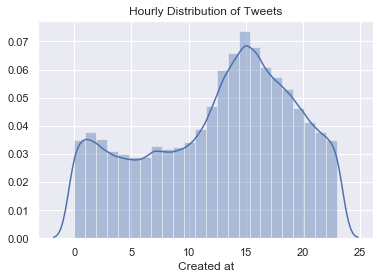

In [ ]:
# Set the seaborn style
sns.set()

# Plot the histogram of hours
sns.distplot(tweets_processed["Created at"].dt.hour, bins=24)
plt.title("Hourly Distribution of Tweets")
plt.show()

## 4. Sentiment Analysis

Get polarity and subjectivity scores of the tweets with TextBlob

In [ ]:
# Add polarities and subkectivities into the DataFrame by using TextBlob
tweets_processed["Polarity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.polarity)
tweets_processed["Subjectivity"] = tweets_processed["Processed"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(tweets_processed[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,0.500000,1.000000
1,0.000000,0.000000
2,0.143182,0.552273
3,0.000000,0.000000
4,0.000000,0.000000
5,0.000000,0.041667
6,0.250000,0.250000
7,-0.025000,0.233333
8,0.136364,0.454545
9,0.000000,0.000000


Classify the polarities. <br>
If, <br>
    polarity > 0   --> **positive** <br>
    polarity = 0   --> **neutral**  <br>
    polarity < 0   --> **negative** <br>

In [ ]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
tweets_processed["Label"] = tweets_processed["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(tweets_processed[["Label"]].head(10))

,Label
0,Positive
1,Neutral
2,Positive
3,Neutral
4,Neutral
5,Neutral
6,Positive
7,Negative
8,Positive
9,Neutral


We can also count them up like the following.

In [ ]:
# Print the value counts of the Label column
print(tweets_processed["Label"].value_counts())

Positive    100794
Neutral      57060
Negative     29198
Name: Label, dtype: int64


We tagged the tweets as positive, neutral, and negative so far. Let's go over our findings deeply. Let's visualize the counts.

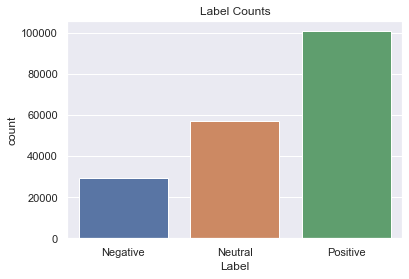

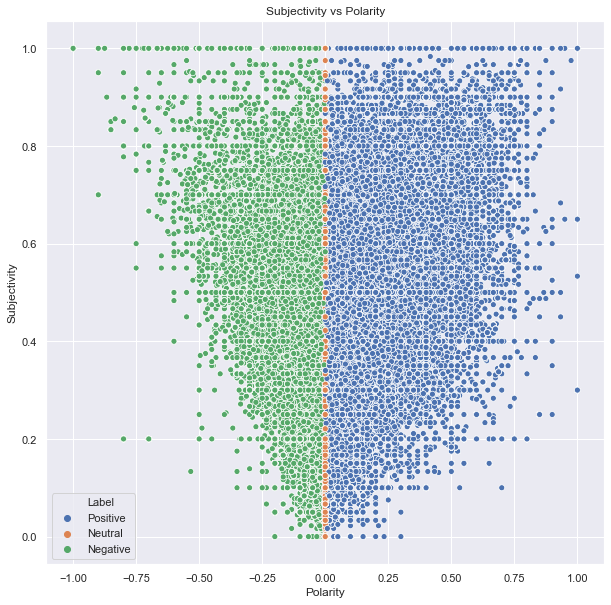

In [ ]:
# Change the datatype as "category"
tweets_processed["Label"] = tweets_processed["Label"].astype("category")

# Visualize the Label counts
sns.countplot(tweets_processed["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=tweets_processed)
plt.title("Subjectivity vs Polarity")
plt.show()

Since the lexicon-based analysis is not always reliable, we have to check the results manually. Let's see the popular (in terms of retweets and favorites) tweets that have the highest/lowest polarity scores.

In [ ]:
# Display the positive tweets
display(tweets_processed.sort_values(by=["Polarity","Favorites","Retweet-Count", ], axis=0, ascending=[False, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

# Display the negative tweets
display(tweets_processed.sort_values(by=["Polarity", "Favorites", "Retweet-Count"], axis=0, ascending=[True, False, False])[["Content","Retweet-Count","Favorites","Polarity"]].head(20))

,Content,Retweet-Count,Favorites,Polarity
79375,@jyrzyap Please tell your classmate. They are very grateful because they have all the equipments in online class. Despite of walang walang gamit ang Teacher niyo. He is doing his best to provide the information needed in your class. Not all Teachers can afford equipments for online class.,65,1286,1.0
84334,omgggg my best fren is in the same online class as me!!!!!,0,257,1.0
13538,Yes! I am making #STEM #STEAM kits for 786 Ss for #distancelearning! Why? Bc #kidsdeserveit! No #bigfrickinpackets! No #workshits! I want to be the best #Teachers for my Ss! @HRussell_STEAM 🎉 https://t.co/6DexYdQuz8,24,245,1.0
177093,I want best online teaching techniques and I will pay for it.\n\nI don't want my career to be idling on streets of MUMBAI.\n\nI am Indian Seafarer.,34,214,1.0
173038,"What works best in the classroom is what works best online, and that’s not passive learning. https://t.co/YJfmN5Qc3C via @slate",60,146,1.0
177947,Some awesome tips for teaching online via @kasal_finley! https://t.co/IzOng1pd6l,66,134,1.0
159192,My partner prepping their online class this semester. I have no idea what’s happening in this system but I’m impressed by their dedication. 😂 #AcademicTwitter https://t.co/nt6shZh8dm,6,133,1.0
38436,Learning Never Exhausts the Mind! Do you know which is the best Indian E-Learning App? Stay tuned to find out tomorrow (7th Aug 2020) at 12 Noon. #AatmaNirbharApp https://t.co/db4dUsZcai,31,118,1.0
160339,"@Kamogelo_MN I hope that we write online examinations even in 2nd semester .Some of us want law firms to be fighting for us once we finish our degrees😂😁 cheers to 10 distinctions ,2020 is our year .#unisa .y'all don't stand a chance against .Unisa produces Di best law attorneys in SA https://t.co/koJjQk0YsW",3,107,1.0
172629,"The #DistanceLearning Playbook book clubs with @CorwinPress for #teachers &amp; leaders start this week. Join @NancyFrey and me as we discuss research-based best teaching, assessment, &amp; planning practices for online classrooms. #edchat\nLearn more &amp; register: https://t.co/ooQZGpGrdW https://t.co/1ClpB9vTYD",35,102,1.0


,Content,Retweet-Count,Favorites,Polarity
59203,I made doodles of @ATiredShota’s mcyt apoc au cause online class is boring https://t.co/ys9A6tNp8q,12,218,-1.0
145606,I’m horrible at remembering to do online assignments so y’all pray for me this semester 🥺,28,66,-1.0
30682,"I want job tog. Ondahala iilonga aaholike,. This e-learning thing is boring mahn",2,47,-1.0
170877,Exams bhi leni hai... \nDuty bhi karvani hai... \nAur fees bhi leni hai.. \n\nAise kese chalega... \n\nAnd after all this insane things they are telling that we are teaching you through online classes!!! \n\n#saynotofees \n#nowornever,24,44,-1.0
81167,Online class is boring and all until one of your Saraiki classmates leave the mic opened,2,41,-1.0
59327,online class is soOO0 BORING,2,20,-1.0
73179,dafaq online class is so boring 😔,1,16,-1.0
34200,Teacher coming out against teaching. They are basically the only ones in favor of e-learning.\n\nThey are pathetic.,0,14,-1.0
151038,All my classes are online this semester and I might go insane 😀,0,14,-1.0
72973,drew an anime version of grim reaper during online class 😗✌️ https://t.co/NVuvwJhiPk,1,13,-1.0


In [ ]:
# Save the DataFrame
tweets_processed.to_csv("tweets_sentiments.csv")

## 5. Buid a Machine Learning model

We have labeled the tweets according to their polarity scores. Let's build a Machine Learning model by using Multinomial Naive Bayes Classifier. Let's start with selection of the features and the target.

In [ ]:
# Encode the labels
le = LabelEncoder()
tweets_processed["Label_enc"] = le.fit_transform(tweets_processed["Label"])

# Display the encoded labels
display(tweets_processed[["Label_enc"]].head())

# Select the features and the target
X = tweets_processed['Processed']
y = tweets_processed["Label_enc"] 

,Label_enc
0,2
1,1
2,2
3,1
4,1


Now, we need to split our data into train and test sets. We'll use stratify parameter of train_test_split since our data is unbalanced.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

We are ready to build our machine learning model

In [ ]:
# Create the tf-idf vectorizer
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.8321304464047046


Evaluate the model

In [ ]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[ 3873   599  1368]
 [  660  9294  1458]
 [ 1591   556 18012]]


Classification Report

              precision    recall  f1-score   support

           0       0.63      0.66      0.65      5840
           1       0.89      0.81      0.85     11412
           2       0.86      0.89      0.88     20159

    accuracy                           0.83     37411
   macro avg       0.80      0.79      0.79     37411
weighted avg       0.84      0.83      0.83     37411



In [ ]:
# Save the model
pickle.dump(nb, open("model.pkl", 'wb'))

## Summary

In summary, let's remember what we did together. Firstly, we have collected the Tweets about distance learning by using Twitter API and tweepy library. After that we applied common preprocessing steps on them such as tokenization, lemmatization, removing stopwords, and so forth. We explored the data by using summary statistics and visualization tools. After all, we used TextBlob to get polarity scores of the tweets and interpreted our findings. Consequently, we found that in our dataset most of the tweets have positive opinions about distance learning. Do not forget the fact that we only used lexicon-based approach which is not very reliable. Finally, we have built a machine learning model to predict tweets sentiments. I hope this story will helpful for you to understand the sentiment analysis of tweets.

In [14]:
# Load the processed DataFrame
tweets_processed = pd.read_csv("tweets_sentiments.csv", parse_dates=["Created at"])